# 03: Test de hipótesis

En una tarea de la lección 1 intentábamos buscar los valores de ciertos coeficientes de Wilson que reprodujeran los valores experimentales de algunos observables. En aquella tarea nos limitamos a buscar una aproximación, pero ahora vamos a identificar la respuesta exacta. Para ello, deberemos:

* Cuantificar cómo de bueno es un conjunto de parámetros (en nuestro caso, coeficientes de Wilson) a la hora de describir los resultados experimentales.
* Obtener los parámetros que mejor describen los datos experimentales.
* Decidir si el resultado obtenido es significativamente mejor que el SM (hipótesis nula).

## Funciones de pérdida


Nuestro objetivo es determinar $n$ parámetros $\vec{\theta}$ definidos en una región $R \subseteq \mathbb{R}^n$. Estos parámetros los emplearemos en un modelo $f_i(\vec{\theta})$ para hacer predicciones $x_i = f_i(\vec{\theta})$ que contrastamos con las observaciones $y_i$.

En nuestro caso, los parámetros $\vec{\theta}$ serán los coeficientes de Wilson, el modelo será el SMEFT, los valores de $x_i$ serán ciertos observables ($R_{K^{(*)}}$, $R_{D^{(*)}}$, $R_{J/\psi}$, ...) que calcularemos mediante la función `np_prediction` de `flavio`, y las observaciones $y_i$ serán las mediciones experimentales para esos mismos observables.

Una función de pérdida o de coste sirve para cuantificar cómo de bien los parámetros $\vec{\theta}$ describen las observaciones $y_i$. Se trata de una función $L: R \to \mathbb{R}$ que tenga un mínimo cuando los valores predichos por el modelo sean iguales a las observaciones.

Una de las funciones de pérdida más comunes es la función cuadrática: $$L(\vec{\theta}) = \sum_i (x_i - y_i)^2 = \sum_i (f_i(\vec{\theta}) - y_i)^2.$$

Veamos la función cuadrática en acción. En este caso, incluiremos dos observables relacionados con los procesos $b\to s\ell\ell$, $R_K$ y $\frac{d\mathrm{BR}}{dq^2}(B\to K\mu^+\mu^-)$, ambos en el bin $q^2 \in [1.1,\ 6.0]\ \mathrm{GeV}^2$. El modelo tendrá dos parámetros $K_1$ y $K_2$, y en vez de usar el SMEFT, simplemente sumaremos $K_i$ a las predicciones del SM:

In [6]:
import flavio

RK_SM = flavio.sm_prediction("<Rmue>(B+->Kll)", 1.1, 6.0)
dBR_SM = flavio.sm_prediction("<dBR/dq2>(B+->Kmumu)", 1.1, 6.0)

RK_exp = flavio.combine_measurements(("<Rmue>(B+->Kll)", 1.1, 6.0)).central_value
dBR_exp = flavio.combine_measurements(("<dBR/dq2>(B+->Kmumu)", 1.1, 6.0)).central_value

In [46]:
def modelo(K1, K2):
    return RK_SM + K1, dBR_SM + K2


def loss(pars, modelo):
    y = (RK_exp, dBR_SM)

    return sum((xi-yi)**2 for xi, yi in zip(modelo(*pars), y))

Veamos el valor de la función de pérdida para $\vec{K} = (0.1, 0)$ y para $\vec{K} = (0, 0.1)$:

In [47]:
loss((0.1, 0), modelo)

0.06303582803555643

In [48]:
loss((0, 0.1), modelo)

0.0328219542413324

Según la función de pérdida que estamos usando, el segundo conjunto de parámetros es mejor que el primero, ya que tiene menor pérdida. Sin embargo, si examinamos las predicciones del modelo en ambos puntos:

In [15]:
modelo(0.1, 0)

(1.1007790786808298, 3.491200391085207e-08)

In [16]:
modelo(0, 0.1)

(1.0007790786808297, 0.10000003491200392)

En el primer caso, estamos modificando el valor de $R_K$ en un 10%, mientras que en el segundo, hemos aumentado el *branching ratio* diferencial en 7 órdenes de magnitud!

La función de pérdida que hemos empleado no funciona bien cuando tenemos observables que abarcan varios órdenes de magnitud. Podemos corregirla si normalizamos los observables. La elección natural para la normalización es la incertidumbre de cada observable.$$L(\vec{\theta}) = \sum_i \frac{(x_i - y_i)^2}{\sigma_i^2} = \sum_i \frac{(f_i(\vec{\theta}) - y_i)^2}{\sigma_i^2}.$$

En la práctica, asumiremos que la incertidumbre tiene dos componentes independientes, experimental y teórica, y que esta última se puede aproximar por la incertidumbre teórica en el SM:

In [17]:
RK_unc_SM = flavio.sm_uncertainty("<Rmue>(B+->Kll)", 1.1, 6.0)
dBR_unc_SM = flavio.sm_uncertainty("<dBR/dq2>(B+->Kmumu)", 1.1, 6.0)

RK_unc_exp = flavio.combine_measurements(("<Rmue>(B+->Kll)", 1.1, 6.0)).error_left
dBR_unc_exp = flavio.combine_measurements(("<dBR/dq2>(B+->Kmumu)", 1.1, 6.0)).error_left

In [49]:
def loss(pars, modelo):
    y = (RK_exp, dBR_SM)
    sigma2 = (RK_unc_SM**2+RK_unc_exp**2, dBR_unc_SM**2+dBR_unc_exp**2)

    return sum((xi-yi)**2/s2i for xi, yi, s2i in zip(modelo(*pars), y, sigma2))

Con esta nueva función de pérdida, obtenemos resultados más coherentes:

In [50]:
loss((0.1, 0), modelo)

52.519297254552264

In [51]:
loss((0, 0.1), modelo)

228238794229687.5

Una última complicación ocurre cuando varios observables no son estadísticamente independientes, ya sea porque su determinación teórica está relacionada (como por ejemplo $R_K$ y $\frac{d\mathrm{BR}}{dq^2}$) o porque las mediciones experimentales emplean el mismo análisis ($R_D$ y $R_{D^*}$). En estos casos, utilizar la desviación estadística de cada observable individualmente hará que se sobreestime la pérdida. En su lugar hay que usar la matriz de covarianza $C$,
$$L(\vec{\theta}) = \sum_{i,j} (x_i - y_i) C^{-1}_{ij} (x_j - y_j) = \sum_{i,j} (f_i(\vec{\theta}) - y_i)C^{-1}_{ij}(f_j(\vec{\theta}) - y_j).$$

La covariancia de dos variaables estadísticas se calcula como $C_{ij} = E[(x_i-E[x_i])(x_j-E[x_j])]$, donde $E[]$ denota el valor esperado. Por lo tanto, los elementos de la diagonal se corresponden con la varianza $C_{ii} = \sigma_i^2$, y en los casos en los que las variables $x_i$ y $x_j$ sean estadísticamente independientes, los términos fuera de la diagonal $C_{ij} = 0$ y la función de pérdida se reduce al caso anterior.

Relacionada con la covarianza se puede definir la correlación, $\mathrm{Corr}_{ij} = \frac{C_{ij}}{\sigma_i\sigma_j}$. Los elementos de la diagonal de la matriz de correlación siempre son iguales a 1, y el resto están comprendidos entre -1 y 1, siendo una correlación nula si las variables son estadísticamente independientes, y $\pm1$ si tienen una relación lineal $x_1 = m x_2$ ($+1$ si $m> 0$ y $-1$ si $m < 0$).

En `flavio` la covarianza en el SM de varios observables se calcula con la función `sm_covariance`, a la que hay que pasarle una lista con los observables:

In [24]:
cov_SM = flavio.sm_covariance([("<Rmue>(B+->Kll)", 1.1, 6.0), ("<dBR/dq2>(B+->Kmumu)", 1.1, 6.0)])

In [25]:
cov_SM[0,1]/(RK_unc_SM*dBR_unc_SM)

-0.3844541118682048

Vamos a calcular la nueva función de pérdida. Para hacer las operaciones con vectores y matrices usaremos `numpy`

In [52]:
import numpy as np

def loss(pars, modelo):
    inv_cov = np.matrix(cov_SM).I
    y = (RK_exp, dBR_SM)
    residuals = np.array([xi-yi for xi, yi in zip(modelo(*pars), y)])
    return float(residuals @ inv_cov @ residuals)

In [53]:
loss((0.1, 0), modelo)

869484.9800030973

In [54]:
loss((0, 0.1), modelo)

276193237137052.28

## Optimización

Ya hemos definido la función de pérdida para determinar si unos parámetros describen bien las observaciones. Ahora tendremos que obtener cuáles son los parámetros que mejor lo hacen. Para ello, tendremos que minimizar la función de pérdida.

En el caso de un modelo lineal $f_i = m_{ij} x_j + b_i$ (como el ejemplo que estamos usando) existe una solución analítica, obtenida por Laplace. Sin embargo, para modelos generales no hay una solución analítica y hay que recurrir a métodos numéricos de optimización.

Usaremos dos paquetes diferentes para la optimización: `scipy` e `iminuit`.

### Optimización con `scipy`

`scipy` es un paquete general de cálculo numérico, que en su módulo `optimze` incluye varias funciones de optimización. La función de propósito general es `minimize`:

In [45]:
from scipy.optimize import minimize

El primer argumento debe ser la función que se va a minimizar, y el segundo el punto en el que se inicia la minimización (mejor cuanto más próximo al mínimo). La función que se minimiza debe tener como primer argumento $\vec{\theta}$, y si tiene más argumentos, en nuestro caso `modelo`, se pasan a través de `args`:

In [57]:
res = minimize(loss, (0, 0), args=(modelo,))

res.x

array([-1.50933317e-01, -8.53390336e-09])

Si no se especifica, la función `minimize` utiliza el [algoritmo BFGS](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm). Este algoritmo necesita calcular el jacobiano de la función pérdida, si se conoce de forma exacta se puede pasar mediante el argumento `jac=`, y si no, lo estima. En los casos en los que no se conoce el jacobiano, normalmente es mejor usar otro algoritmo que no lo requiera, por ejemplo [Nelder-Mead](https://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method)

In [58]:
res = minimize(loss, (0, 0), args=(modelo,), method="nelder-mead")

res.x

array([-1.51068087e-01, -4.35527849e-11])

## Optimización con `iminuit`

[`iminuit`](https://iminuit.readthedocs.io/en/stable/) es un paquete específico para minimizar funciones de pérdida, basado en el algoritmo [Minuit](https://root.cern.ch/download/minuit.pdf) desarrollado por el CERN.

In [69]:
from iminuit import Minuit

En este caso, la función de pérdida solamente puede aceptar como argumentos los parámetros y nada más, así que tendremos que hacer una pequeña modificación:

In [75]:
def loss(pars):
    inv_cov = np.matrix(cov_SM).I
    y = (RK_exp, dBR_SM)
    residuals = np.array([xi-yi for xi, yi in zip(modelo(*pars), y)])
    return float(residuals @ inv_cov @ residuals)

Empezamos definiendo una instancia de tipo `Minuit` para nuestro problema de minimización:

In [76]:
m = Minuit(loss, (0.0, 0.0))

In [77]:
m

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,x0,0.0,0.1,,,,,
1,x1,0.0,0.1,,,,,


Si la función de pérdida tiene argumentos con nombre, los podemos usar en la iniciación de la instancia de `Minuit`:

In [78]:
def loss(K1, K2):
    inv_cov = np.matrix(cov_SM).I
    y = (RK_exp, dBR_SM)
    residuals = np.array([xi-yi for xi, yi in zip(modelo(K1, K2), y)])
    return float(residuals @ inv_cov @ residuals)

m = Minuit(loss, K2=0, K1=0)

In [79]:
m

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,K1,0.0,0.1,,,,,
1,K2,0.0,0.1,,,,,


Podemos fijar algunos de los parámetros a su valor actual, de modo que no se modificarán durante la minimización:

In [80]:
m.fixed["K2"] = True

In [81]:
m

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,K1,0.0,0.1,,,,,
1,K2,0.0,0.1,,,,,yes


La función `migrad` se encarga de realizar la minimización:

In [82]:
m.fixed["K2"] = False
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 7.076e-22                  │              Nfcn = 39               │
│ EDM = 7.11e-22 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ K1   │-151.07e-3 │  0.29e-3  │            │            │         │         │       │
│ 1 │ K2   │   -0e-9   │   6e-9    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────┐
│    │        K1        K2 │
├────┼─────────────────────┤
│ K1 │   8.3e-08 -6.61e-13 │
│ K2 │ -6.61e-13  4.15e-17 │
└────┴─────────────────────┘

In [84]:
m.values["K1"]

-0.15106936897112225

In [85]:
m.values["K2"]

-1.3552527156068805e-19

Además del valor de los parámetros, iminuit también estima su incertidumbre, covarianza y correlación:

In [87]:
m.errors["K1"]

0.0002881663196009644

In [88]:
m.errors["K2"]

6.439901652912929e-09

In [89]:
m.covariance

,K1,K2
K1,8.3e-08,-6.61e-13 (-0.356)
K2,-6.61e-13 (-0.356),4.15e-17


In [91]:
m.covariance.correlation()

,K1,K2
K1,1,-0.356
K2,-0.356,1


Aunque `migrad` realiza una estimación de los errores y covarianza, es recomendable llamar después a la función `hesse` para refinar la estimación:

In [92]:
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 7.076e-22                  │              Nfcn = 49               │
│ EDM = 7.08e-22 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ K1   │-151.07e-3 │  0.29e-3  │            │            │         │         │       │
│ 1 │ K2   │   -0e-9   │   6e-9    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────┐
│    │        K1        K2 │
├────┼─────────────────────┤
│ K1 │   8.3e-08 -6.61e-13 │
│ K2 │ -6.61e-13  4.15e-17 │
└────┴─────────────────────┘

Los errores calculados por `migrad`/`hesse` se calculan asumiendo que la función de pérdida alrededor del mínimo se puede aproximar de forma adecuada por una función cuadrática. Para funciones más irregulares, en las que los errores en general no son simétricos, hay que usar la función `minos`:

In [93]:
m.minos()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 7.076e-22                  │              Nfcn = 73               │
│ EDM = 7.08e-22 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ K1   │-151.07e-3 │  0.29e-3  │  -0.29e-3  │  0.29e-3   │         │         │       │
│ 1 │ K2   │   -0e-9   │   6e-9    │   -6e-9    │    6e-9    │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┐
│          │          K1           │          K2           │
├──────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │ -0.29e-3  │  0.29e-3  │   -6e-9   │   6e-9    │
│  Valid   │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┘
┌────┬─────────────────────┐
│    │        K1        K2 │
├────┼─────────────────────┤
│ K1 │   8.3e-08 -6.61e-13 │
│ K2 │ -6.61e-13  4.15e-17 │
└────┴─────────────────────┘

In [99]:
m.merrors["K1"].lower

-0.00028816631961365885

In [102]:
m.merrors["K1"].upper

0.00028816631961821077

Para funciones más complicadas, `migrad` puede ser relativamente lento, por lo que es recomendable hacer una fase previa de minimización. Para ello, `iminuit` cuenta con la función `simplex`, que implementa el algoritmo de Nelder-Mead:

In [103]:
m = Minuit(loss, K2=0, K1=0)
m.simplex()
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.103e-22                  │              Nfcn = 116              │
│ EDM = 1.1e-22 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ K1   │-151.07e-3 │  0.29e-3  │            │            │         │         │       │
│ 1 │ K2   │   -0e-9   │   6e-9    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────┐
│    │        K1        K2 │
├────┼─────────────────────┤
│ K1 │   8.3e-08 -6.61e-13 │
│ K2 │ -6.61e-13  4.15e-17 │
└────┴─────────────────────┘

## Teorema de Wilks

La función de verosimilitud (likelihood) es una función $\mathcal{L}(\vec{\theta})$ de los parámetros del modelo que indica la probabilidad de que se obtengan las observaciones dados los valores de los parámetros, esto es, $\mathcal{L}(\vec{\theta}) = P(Y|\Theta=\vec{\theta})$.

Los parámetros $\vec{\theta}$ se pueden estimar usando el estimador de máxima likelihood: se seleccionan los valores de $\vec{\theta}$ que maximicen el valor de la función de likelihood.

Veamos un ejemplo concreto de unas variables que cumplan un modelo $y_i \sim f_i(x; \vec{\theta})$, y cuyas observaciones sigan una distribución gaussiana:

$$\mathcal{L}(\vec{\theta}) = P(y|\vec{\theta}) = \prod_{i=1}^N \frac{1}{\sqrt{2\pi\sigma^2}} \mathrm{exp}\left(-\frac{(y_i- f(x_i))^2}{\sigma^2}\right) = \frac{1}{(2\pi)^{N/2}\sigma^N} \mathrm{exp}\left(\sum_{i=1}^N \frac{-(y_i - f(x_i))^2}{2\sigma^2} \right).$$

Podemos minimizar analíticamente calculando $\frac{\partial \mathcal{L}}{\partial \vec{\theta}}$. Sin embargo, se puede comprobar fácilmente que el máximo de la función se consigue cuando se minimiza la potencia del exponente, es decir, en el mínimo de
$$\sum_{i=1}^N \frac{(y_i - f(x_i))^2}{2\sigma^2}.$$

Por lo tanto, la función de pérdida cuadrática es un caso particular de estimador de máxima likelihood cuando los errores son gaussianos. Este es un caso bastante frecuente (entre otros motivos, debido al teorema del límite central), por lo que en general consideraremos que los errores son gaussianos a no ser que especifiquemos lo contrario.

El teorema de Wilks nos permite usar la función de likelihood para aceptar o rechazar una hipótesis. Tenemos dos hipótesis: la hipótesis nula $\vec{\theta}_0$, y la hipótesis alternativa $\vec{\theta}$, que usualmente se toma como los parámetros de máxima likelihood distintos a la hipótesis nula. Construímos un test estadístico dividiendo el logaritmo de las dos funciones de likelihood,

$$D = -2\frac{\log \mathcal{L}(\vec{\theta}_0)}{\log \mathcal{L}(\vec{\theta})}$$

Bajo condiciones bastante generales, esta $D$ es una variable estadística distribuída según una distribución $\chi^2$, con el número de grados de libertad dado por $n_D = n - n_0$, la diferencia de grados de libertad de la hipótesis alternativa y la hipótesis nula. La hipótesis nula se rechaza con una significancia $\alpha$ si $D < c$, donde $c$ es el valor tal que $P_{\chi^2}(c; n_D) = \alpha$. Es decir, $\alpha$ es la probabilidad de que la hipótesis nula pueda producir aleatoriamente las observaciones.

El valor de $c$ correspondiente a $n_D$ grados de libertad y significancia $\alpha$ se puede calcular con `scipy`:

In [110]:
from scipy.stats import chi2

n_D = 5
alpha = 0.995
chi2(n_D).ppf(alpha)

16.74960234363904

y también podemos obtener la significancia de la hipótesis si conocemos el ratio de los logaritmos de likelihood

In [120]:
ratio_logL = 15
n_D = 5
chi2(n_D).cdf(ratio_logL)

0.9896376620842136

En algunas áreas, incluyendo la física de partículas, la significancia no se suele reportar como una probabilidad, sino como "sigmas", esto es, el número $n$ tal que el área entre $-n$ y $+n$ bajo una gaussiana de media 0 y varianza 1 sea igual a $\alpha$. Para obtener $\alpha$ a partir del número de sigmas:

In [112]:
from scipy.stats import norm

def significancia(nsigma):
    return 2*(norm.cdf(nsigma)-0.5)

for n in range(1, 5):
    print(f"{n} sigmas: alpha = {significancia(n)}")

1 sigmas: alpha = 0.6826894921370859
2 sigmas: alpha = 0.9544997361036416
3 sigmas: alpha = 0.9973002039367398
4 sigmas: alpha = 0.9999366575163338


y a la inversa, obtener el número de sigmas que corresponde a una cierta significancia:

In [118]:
def nsigmas(alpha):
    return norm.ppf(0.5+alpha/2)

print(nsigmas(0.9))

1.6448536269514722


En otras áreas, en vez de la significancia o el número de sigmas se emplea el valor-$p$, que es simplemente $1-\alpha$.

Usando `iminuit` (si `matplotlib` está instalado) se pueden obtener gráficos de likelihood constante para pares de parámetros. Hay dos funciones, `draw_contour` y `draw_mncontour`, que usan los datos de `migrad`/`hesse` y de `minos` respectivamente. Se asume que los errores están distribuidos de forma gaussiana, por lo que el ratio de los logaritmos de likelihood es simplemente la diferencia de la función de pérdida. Se representa la diferencia entre la función de pérdida en cada punto y en el mínimo. Si no se pasan más argumentos, representa solamente a una significancia de 0.68 (1 sigma):

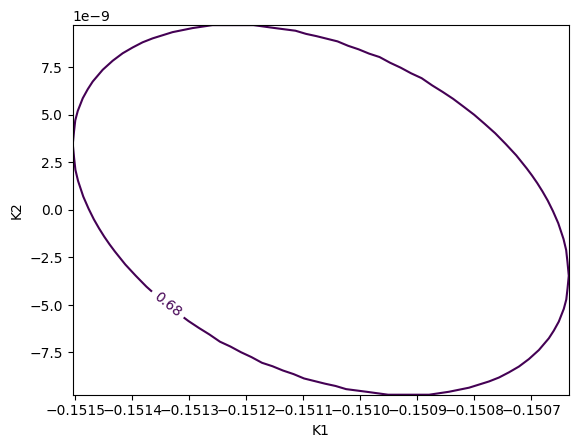

In [121]:
m.draw_mncontour("K1", "K2")

Pasando varios valores entre 0 y 1, los interpreta como significancias:

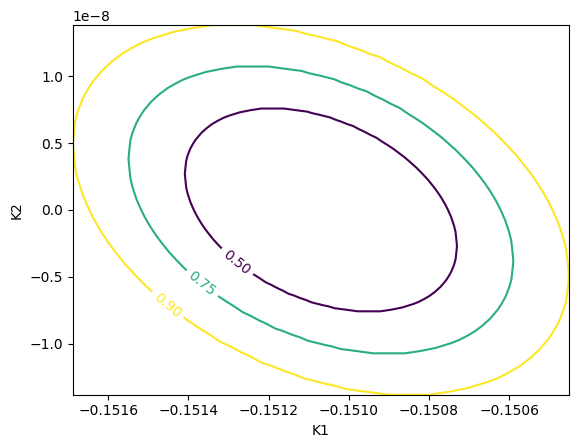

In [122]:
m.draw_mncontour("K1", "K2", cl = [0.5, 0.75, 0.9])

y pasando valores mayores que 1, como número de sigmas:

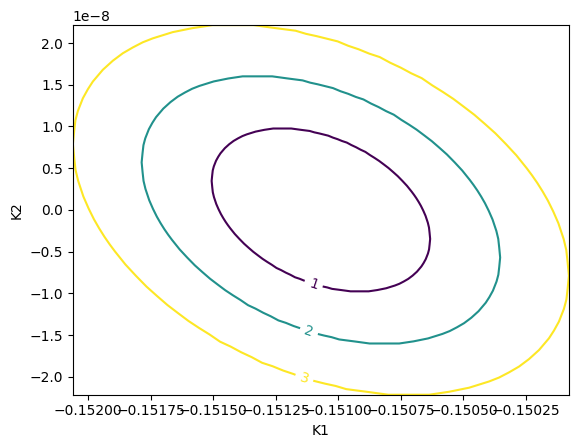

In [123]:
m.draw_mncontour("K1", "K2", cl = [1, 2, 3])

Y la función `draw_mnmatrix` representa los gráficos de likelihood constante para cada par de parámetros, y la función de likelihood marginalizada para cada parámetro:

(<Figure size 640x480 with 4 Axes>,
 array([[<AxesSubplot: >, <AxesSubplot: >],
        [<AxesSubplot: xlabel='K1', ylabel='K2'>,
         <AxesSubplot: xlabel='K2'>]], dtype=object))

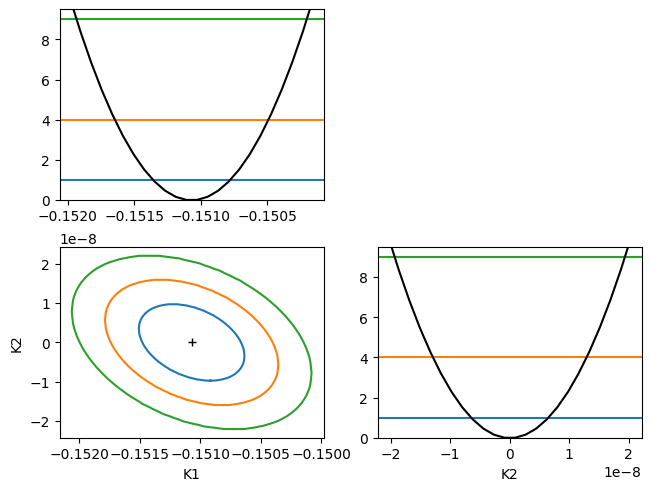

In [125]:
m.draw_mnmatrix(cl=[1, 2, 3])